In [228]:
# XWhiff Inference Analysis - Pitch Tunneling and Effectiveness Study
# This notebook analyzes the relationship between pitch characteristics and swing-and-miss outcomes
# Focus: How do pitch combinations and movement differences affect whiff rates?
#
# Import necessary libraries for data analysis and visualization
import pandas as pd                    # Data manipulation and analysis
import numpy as np                     # Numerical operations and statistical functions
import xgboost as xgb                  # Machine learning framework (if needed for additional analysis)
from xgboost import XGBClassifier      # Classifier for potential model comparisons
from sklearn.linear_model import LogisticRegression  # Alternative modeling approach
import matplotlib.pyplot as plt        # Basic plotting functionality
import seaborn as sns                  # Statistical data visualization and regression plots

In [229]:
xwhiff_2024 = pd.read_csv('./whiff_csvs/2024_xwhiff_college.csv',low_memory=False)


In [230]:
xwhiff_2024.head()


,PitcherThrows,BatterSide,Outs,Balls,Strikes,TaggedPitchType,PitchCall,RelSpeed,VertRelAngle,HorzRelAngle,...,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,VertApprAngle,HorzApprAngle,PitcherId,whiff,count,xwhiff
0,Right,Right,0,0,0,Slider,BallCalled,86.34831,-5.087035,-0.556059,...,-1.26150,-6.71201,-1.24052,-0.79734,-12.231122,-1.751516,1.000234e+09,0,0-0,0.000063
1,Right,Right,0,1,0,Fastball,StrikeCalled,94.49974,-3.133086,-0.492520,...,20.20828,3.49654,3.00046,0.29788,-5.365324,0.134391,1.000234e+09,0,1-0,0.116447
2,Right,Right,0,1,1,Fastball,FoulBallNotFieldable,94.81021,-3.910073,-1.135525,...,22.06875,-0.43740,2.48669,-0.87744,-5.815582,-1.213668,1.000234e+09,0,1-1,0.002141
3,Right,Right,0,1,2,Slider,FoulBallNotFieldable,86.30865,-1.385858,-0.791508,...,2.34610,-6.38485,2.69703,-1.15108,-7.862841,-1.929632,1.000234e+09,0,1-2,0.000080
4,Right,Right,0,1,2,Slider,BallCalled,87.45870,-4.605749,-1.323250,...,0.27646,-4.37162,-0.43496,-1.44974,-11.264591,-2.102031,1.000234e+09,0,1-2,0.000003


# Pitch Tunneling Analysis: Research Question and Methodology

## Research Objective
**Primary Question**: Which pitch combinations "tunnel" most effectively to maximize swing-and-miss outcomes?

## Tunneling Hypothesis
**Core Concept**: Certain pitch shapes appear similar to batters until late in their trajectory, creating deception that leads to poor swing decisions. The most effective combinations should:
1. Look identical early in flight (good tunneling)
2. Diverge significantly late in trajectory (create deception)
3. Result in higher whiff rates

## Analytical Framework

### Key Metrics Analyzed
We focus on three fundamental pitch characteristics that define the pitch's trajectory:
- **Horizontal Movement**: X-axis component of pitch path
- **Velocity (RelSpeed)**: Y-axis component representing timing
- **Vertical Movement**: Z-axis component of pitch path

These three metrics capture the complete spatial and temporal profile that batters must process.

### Methodology
1. **Pitcher-Level Aggregation**: Calculate average metrics for each pitch type per pitcher
2. **Pairwise Comparisons**: Subtract every pitch type from every other pitch type for each metric
3. **Correlation Analysis**: Test relationship between pitch differences and xWhiff effectiveness
4. **Statistical Validation**: Use bootstrap confidence intervals to assess significance

### Data Requirements
- Minimum 50 pitches per pitch type per pitcher (ensures established arsenal)
- Six main pitch types: Fastball, Sinker, Slider, Curveball, ChangeUp, Cutter
- Focus on pitcher-specific differences rather than league averages

In [231]:
# Convert PitcherId to integer for proper grouping operations
# Ensures consistent data type for pitcher-level aggregations
xwhiff_2024['PitcherId'] = xwhiff_2024['PitcherId'].astype(int)

In [232]:
# Define the key metrics and pitch types for tunneling analysis
# These represent the fundamental characteristics that define pitch effectiveness

# Core pitch metrics that define trajectory and timing
metrics = ['RelSpeed', 'HorzBreak', 'InducedVertBreak']

# Six primary pitch types in modern baseball
pitches = ['Fastball', 'Sinker', 'Cutter', 'ChangeUp', 'Curveball', 'Slider']

In [233]:
# Calculate pitcher-specific average metrics for each pitch type
# This creates a clean dataset focused on established pitch arsenals

# Step 1: Calculate average metrics per pitcher per pitch type
# Include RelSpeed (velocity), HorzBreak, InducedVertBreak, and xWhiff
xwhiff_grouped = xwhiff_2024.groupby(['PitcherId', 'TaggedPitchType'])[
    ['RelSpeed', 'HorzBreak', 'InducedVertBreak', 'xwhiff']
].mean().reset_index().rename(columns={metric: f"avg_{metric}" for metric in metrics})

# Step 2: Count pitches thrown by each pitcher for each pitch type
pitch_count = xwhiff_2024[['PitcherId', 'TaggedPitchType']].groupby(
    ['PitcherId', 'TaggedPitchType']
).size().reset_index().rename(columns={0: 'count'})

# Step 3: Merge count data with averages
xwhiff_grouped = xwhiff_grouped.merge(pitch_count, on=['PitcherId', 'TaggedPitchType'], how='left')

# Step 4: Filter to established pitches only (minimum 50 throws)
# This ensures we're analyzing pitches that are truly part of the pitcher's arsenal
# Removes occasional/experimental pitches that might skew analysis
xwhiff_grouped = xwhiff_grouped[xwhiff_grouped['count'] >= 50]

print(f"Analysis includes {len(xwhiff_grouped)} pitcher-pitch combinations")
print(f"Covering {xwhiff_grouped['PitcherId'].nunique()} unique pitchers")
xwhiff_grouped


,PitcherId,TaggedPitchType,avg_RelSpeed,avg_HorzBreak,avg_InducedVertBreak,xwhiff,count
9,91395,Fastball,89.838784,9.925560,15.367321,0.063760,87
13,97356,Fastball,89.130841,15.201723,12.945524,0.106230,64
33,573277,Fastball,89.538679,17.585764,6.686409,0.058556,265
35,573277,Slider,77.652050,-10.675676,-1.081654,0.100952,92
45,675477,Fastball,90.751158,18.908903,7.518277,0.099049,208
...,...,...,...,...,...,...,...
22820,90000243869,Fastball,89.803565,8.468673,15.643180,0.066317,151
22821,90000243869,Slider,79.847139,-3.055462,0.126260,0.078460,73
22824,90000255721,Cutter,84.723959,-4.205017,7.630087,0.276659,59
22825,90000255721,Fastball,89.400117,7.159172,15.546883,0.087345,116


In [234]:
# Reshape data into wide format for easier pairwise comparisons
# Each row represents one pitcher with columns for each pitch type's characteristics

# Pivot to create a wide table with pitch types as columns
# This structure enables easy calculation of differences between pitch types
xwhiff_pivot = xwhiff_grouped.pivot_table(
    index='PitcherId',
    columns='TaggedPitchType', 
    values=['avg_RelSpeed', 'avg_HorzBreak', 'avg_InducedVertBreak', 'xwhiff', 'count']
)

# Flatten column names for easier access: "PitchType_Metric" format
xwhiff_pivot.columns = [f"{pitch}_{metric}" for metric, pitch in xwhiff_pivot.columns]
xwhiff_pivot = xwhiff_pivot.reset_index()

print(f"Pivot table shape: {xwhiff_pivot.shape}")
print("Each row represents one pitcher's arsenal characteristics")
xwhiff_pivot

,PitcherId,ChangeUp_avg_HorzBreak,Curveball_avg_HorzBreak,Cutter_avg_HorzBreak,Fastball_avg_HorzBreak,Sinker_avg_HorzBreak,Slider_avg_HorzBreak,ChangeUp_avg_InducedVertBreak,Curveball_avg_InducedVertBreak,Cutter_avg_InducedVertBreak,...,Cutter_count,Fastball_count,Sinker_count,Slider_count,ChangeUp_xwhiff,Curveball_xwhiff,Cutter_xwhiff,Fastball_xwhiff,Sinker_xwhiff,Slider_xwhiff
0,91395,NaN,NaN,NaN,9.925560,NaN,NaN,NaN,NaN,NaN,...,NaN,87.0,NaN,NaN,NaN,NaN,NaN,0.063760,NaN,NaN
1,97356,NaN,NaN,NaN,15.201723,NaN,NaN,NaN,NaN,NaN,...,NaN,64.0,NaN,NaN,NaN,NaN,NaN,0.106230,NaN,NaN
2,573277,NaN,NaN,NaN,17.585764,NaN,-10.675676,NaN,NaN,NaN,...,NaN,265.0,NaN,92.0,NaN,NaN,NaN,0.058556,NaN,0.100952
3,675477,NaN,NaN,NaN,18.908903,20.545266,-15.092268,NaN,NaN,NaN,...,NaN,208.0,65.0,233.0,NaN,NaN,NaN,0.099049,0.104111,0.108172
4,676147,NaN,NaN,0.963111,13.298973,NaN,0.158859,NaN,NaN,0.992701,...,50.0,52.0,NaN,259.0,NaN,NaN,0.131707,0.052355,NaN,0.175715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3509,90000235966,15.526828,NaN,NaN,14.559831,18.194104,-6.846825,5.657467,NaN,NaN,...,NaN,99.0,242.0,131.0,0.064495,NaN,NaN,0.064122,0.043287,0.104004
3510,90000241837,NaN,NaN,NaN,8.593005,NaN,NaN,NaN,NaN,NaN,...,NaN,53.0,NaN,NaN,NaN,NaN,NaN,0.110107,NaN,NaN
3511,90000243869,14.519096,NaN,NaN,8.468673,NaN,-3.055462,8.069866,NaN,NaN,...,NaN,151.0,NaN,73.0,0.163791,NaN,NaN,0.066317,NaN,0.078460
3512,90000255721,NaN,NaN,-4.205017,7.159172,NaN,NaN,NaN,NaN,7.630087,...,59.0,116.0,NaN,NaN,NaN,NaN,0.276659,0.087345,NaN,NaN


In [235]:
# Calculate pairwise differences between all pitch types for tunneling analysis
# This creates difference metrics that quantify how distinct each pitch pair is

print("Calculating pairwise pitch differences...")
difference_columns_created = 0

# Generate all possible pitch-to-pitch comparisons
for pitch1 in pitches:
    for pitch2 in pitches:
        if pitch1 != pitch2:  # Don't compare a pitch to itself
            for metric in metrics:
                # Construct column names for the two pitches being compared
                col1 = f"{pitch1}_avg_{metric}"  
                col2 = f"{pitch2}_avg_{metric}"  
                
                # Only create difference if both pitch types exist in data
                if col1 in xwhiff_pivot.columns and col2 in xwhiff_pivot.columns:
                    # Create difference column: Pitch1 - Pitch2
                    diff_col = f"{pitch1}_minus_{pitch2}_{metric}"
                    xwhiff_pivot[diff_col] = xwhiff_pivot[col1] - xwhiff_pivot[col2]
                    difference_columns_created += 1

print(f"Created {difference_columns_created} difference columns")
print("NaN values indicate pitcher doesn't throw one or both pitch types in the comparison")

# Display the enhanced dataset
xwhiff_pivot

,PitcherId,ChangeUp_avg_HorzBreak,Curveball_avg_HorzBreak,Cutter_avg_HorzBreak,Fastball_avg_HorzBreak,Sinker_avg_HorzBreak,Slider_avg_HorzBreak,ChangeUp_avg_InducedVertBreak,Curveball_avg_InducedVertBreak,Cutter_avg_InducedVertBreak,...,Slider_minus_Sinker_InducedVertBreak,Slider_minus_Cutter_RelSpeed,Slider_minus_Cutter_HorzBreak,Slider_minus_Cutter_InducedVertBreak,Slider_minus_ChangeUp_RelSpeed,Slider_minus_ChangeUp_HorzBreak,Slider_minus_ChangeUp_InducedVertBreak,Slider_minus_Curveball_RelSpeed,Slider_minus_Curveball_HorzBreak,Slider_minus_Curveball_InducedVertBreak
0,91395,NaN,NaN,NaN,9.925560,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,97356,NaN,NaN,NaN,15.201723,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,573277,NaN,NaN,NaN,17.585764,NaN,-10.675676,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,675477,NaN,NaN,NaN,18.908903,20.545266,-15.092268,NaN,NaN,NaN,...,-10.170198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,676147,NaN,NaN,0.963111,13.298973,NaN,0.158859,NaN,NaN,0.992701,...,NaN,0.543671,-0.804253,-0.852537,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3509,90000235966,15.526828,NaN,NaN,14.559831,18.194104,-6.846825,5.657467,NaN,NaN,...,-14.462948,NaN,NaN,NaN,3.231737,-22.373653,-10.772622,NaN,NaN,NaN
3510,90000241837,NaN,NaN,NaN,8.593005,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3511,90000243869,14.519096,NaN,NaN,8.468673,NaN,-3.055462,8.069866,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.180969,-17.574558,-7.943606,NaN,NaN,NaN
3512,90000255721,NaN,NaN,-4.205017,7.159172,NaN,NaN,NaN,NaN,7.630087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [236]:
#adding the side the pitcher throws to to the xwhiff_pivot dataframe
p_throws = xwhiff_2024[['PitcherId','PitcherThrows']].groupby('PitcherId').first().reset_index()
xwhiff_pivot = xwhiff_pivot.merge(p_throws,on='PitcherId',how='left')

In [237]:
# Create chase rate metric as an alternative effectiveness measure
# Chase rate = percentage of swings on pitches outside the strike zone
# This is often easier to achieve than whiffs and may show different patterns

# Step 1: Define the strike zone boundaries (approximate MLB zone)
# Height: 1.5 to 3.5 feet, Width: -0.83 to +0.83 feet from plate center
xwhiff_2024['in_zone'] = np.where(
    (xwhiff_2024['PlateLocHeight'] < 3.5) & 
    (xwhiff_2024['PlateLocHeight'] > 1.5) & 
    (xwhiff_2024['PlateLocSide'] > -0.83) & 
    (xwhiff_2024['PlateLocSide'] < 0.83), 
    1, 0
)

# Step 2: Identify chase situations (swings at pitches outside the zone)
# Include all swing outcomes: contact, foul balls, and whiffs
swing_outcomes = ['InPlay', 'StrikeSwinging', 'FoulBallNotFieldable', 'FoulBall', 'FoulBallFieldable']
xwhiff_2024['chase'] = np.where(
    (xwhiff_2024['PitchCall'].isin(swing_outcomes)) & (xwhiff_2024['in_zone'] == 0),
    1, 0
)

# Step 3: Calculate chase rate by pitcher and pitch type
chase_rate = xwhiff_2024.groupby(['PitcherId', 'TaggedPitchType'])['chase'].mean().reset_index()

# Step 4: Pivot to wide format matching our main dataset structure
chase_rate = chase_rate.pivot_table(
    index='PitcherId', 
    columns='TaggedPitchType', 
    values='chase'
).reset_index()

# Step 5: Add descriptive column names
chase_rate.columns = [f"{col}_chase%" for col in chase_rate.columns]
chase_rate = chase_rate.rename(columns={'PitcherId_chase%': 'PitcherId'})

print(f"Chase rate calculated for {len(chase_rate)} pitchers")


In [238]:
xwhiff_pivot = xwhiff_pivot.merge(chase_rate,on='PitcherId',how='left')
xwhiff_pivot

,PitcherId,ChangeUp_avg_HorzBreak,Curveball_avg_HorzBreak,Cutter_avg_HorzBreak,Fastball_avg_HorzBreak,Sinker_avg_HorzBreak,Slider_avg_HorzBreak,ChangeUp_avg_InducedVertBreak,Curveball_avg_InducedVertBreak,Cutter_avg_InducedVertBreak,...,Slider_minus_Curveball_RelSpeed,Slider_minus_Curveball_HorzBreak,Slider_minus_Curveball_InducedVertBreak,PitcherThrows,ChangeUp_chase%,Curveball_chase%,Cutter_chase%,Fastball_chase%,Sinker_chase%,Slider_chase%
0,91395,NaN,NaN,NaN,9.925560,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Right,0.120000,0.000000,0.000000,0.080460,NaN,0.000000
1,97356,NaN,NaN,NaN,15.201723,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Right,0.500000,0.000000,NaN,0.187500,NaN,0.421053
2,573277,NaN,NaN,NaN,17.585764,NaN,-10.675676,NaN,NaN,NaN,...,NaN,NaN,NaN,Right,0.240000,0.125000,NaN,0.105660,0.000000,0.097826
3,675477,NaN,NaN,NaN,18.908903,20.545266,-15.092268,NaN,NaN,NaN,...,NaN,NaN,NaN,Right,0.259259,0.090909,NaN,0.125000,0.107692,0.167382
4,676147,NaN,NaN,0.963111,13.298973,NaN,0.158859,NaN,NaN,0.992701,...,NaN,NaN,NaN,Right,0.000000,0.250000,0.240000,0.019231,0.000000,0.231660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3509,90000235966,15.526828,NaN,NaN,14.559831,18.194104,-6.846825,5.657467,NaN,NaN,...,NaN,NaN,NaN,Right,0.287879,0.027778,NaN,0.090909,0.181818,0.129771
3510,90000241837,NaN,NaN,NaN,8.593005,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Right,0.000000,NaN,0.000000,0.018868,NaN,0.222222
3511,90000243869,14.519096,NaN,NaN,8.468673,NaN,-3.055462,8.069866,NaN,NaN,...,NaN,NaN,NaN,Right,0.244186,NaN,NaN,0.125828,NaN,0.123288
3512,90000255721,NaN,NaN,-4.205017,7.159172,NaN,NaN,NaN,NaN,7.630087,...,NaN,NaN,NaN,Right,0.333333,0.000000,0.118644,0.077586,NaN,0.157895


In [239]:
RHP = xwhiff_pivot[xwhiff_pivot['PitcherThrows'] == 'Right']
LHP = xwhiff_pivot[xwhiff_pivot['PitcherThrows'] == 'Left']

In [240]:
# Bootstrap function to calculate confidence intervals for correlation coefficients
# This provides statistical rigor by quantifying uncertainty in our correlation estimates
def bootstrap_correlation(series1, series2, n_iterations=1000):
    """
    Calculate 95% confidence interval for correlation coefficient using bootstrap resampling
    
    Bootstrap resampling helps us understand:
    1. How confident we can be in the observed correlation
    2. Whether the correlation is statistically significant
    3. The range of plausible correlation values
    
    Args:
        series1: First variable (e.g., pitch difference metric)
        series2: Second variable (e.g., xWhiff rate)
        n_iterations: Number of bootstrap samples (default 1000)
        
    Returns:
        Tuple of (lower_bound, upper_bound) for 95% confidence interval
    """
    rng = np.random.default_rng(seed=42)  # Set seed for reproducibility
    correlations = np.empty(shape=n_iterations)
    
    # Remove missing values to ensure clean calculation
    # Align both series to have same valid observations
    combined = pd.DataFrame({'x': series1, 'y': series2}).dropna()
    if len(combined) < 10:  # Need minimum observations for meaningful bootstrap
        return np.nan, np.nan
        
    series1_clean = combined['x']
    series2_clean = combined['y']

    # Generate bootstrap correlation estimates
    for i in range(n_iterations):
        # Sample with replacement
        bootstrap_indices = rng.choice(len(series1_clean), size=len(series1_clean), replace=True)
        sample1 = series1_clean.iloc[bootstrap_indices]
        sample2 = series2_clean.iloc[bootstrap_indices]
        
        # Calculate correlation for this bootstrap sample
        correlations[i] = np.corrcoef(sample1, sample2)[0, 1]
    
    # Calculate 95% confidence interval
    lower_bound = np.percentile(correlations, 2.5)
    upper_bound = np.percentile(correlations, 97.5)
    
    return np.round(lower_bound, 3), np.round(upper_bound, 3)

Text(0, 0.5, 'Average Slider xwhiff')

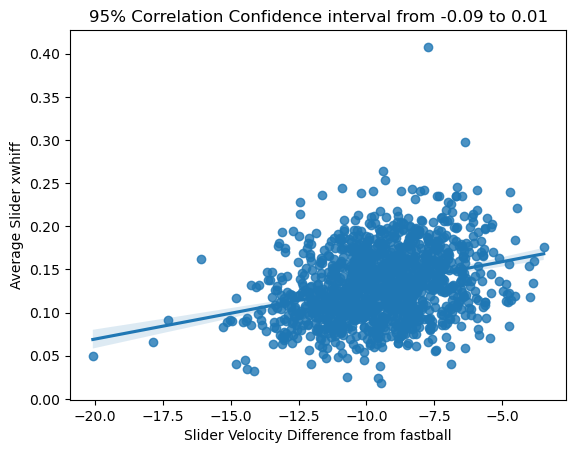

In [241]:
# Analyze velocity tunneling: Slider vs Fastball for Right-handed pitchers
# Research question: Does having a larger velocity difference improve slider effectiveness?

sns.regplot(RHP, x='Slider_minus_Fastball_RelSpeed', y='Slider_xwhiff', 
           scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})

# Calculate statistical significance of the relationship
lower, upper = bootstrap_correlation(RHP['Slider_minus_Fastball_RelSpeed'], RHP['Slider_xwhiff'])

plt.title(f'Slider-Fastball Velocity Separation vs Slider Effectiveness\n95% CI: [{lower}, {upper}]')
plt.xlabel('Slider Velocity Difference from Fastball (mph)')
plt.ylabel('Average Slider xWhiff Rate')
plt.grid(True, alpha=0.3)

# Interpretation guide
if lower > 0:
    print("Positive correlation: Larger velocity differences associated with higher whiff rates")
elif upper < 0:
    print("Negative correlation: Smaller velocity differences associated with higher whiff rates")
else:
    print("No significant correlation: Velocity difference doesn't predict slider effectiveness")

Text(0, 0.5, 'Average Slider xwhiff')

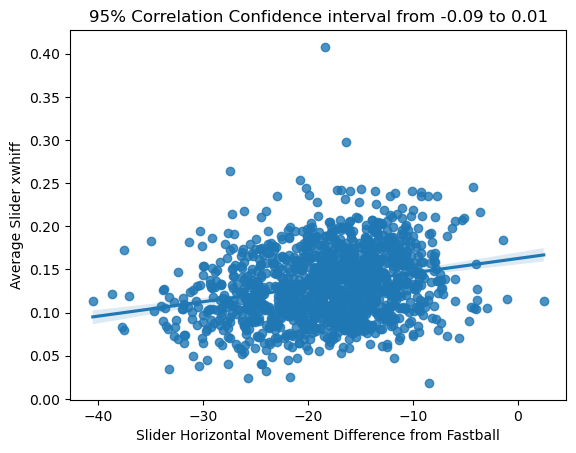

In [242]:
sns.regplot(RHP,x='Slider_minus_Fastball_HorzBreak',y='Slider_xwhiff')
lower, upper = bootstrap_correlation(RHP['Slider_minus_Fastball_HorzBreak'],RHP['Slider_xwhiff'])
plt.title(f'95% Correlation Confidence interval from {lower} to {upper}')
plt.xlabel('Slider Horizontal Movement Difference from Fastball')
plt.ylabel('Average Slider xwhiff')

Text(0, 0.5, 'Average Slider xwhiff')

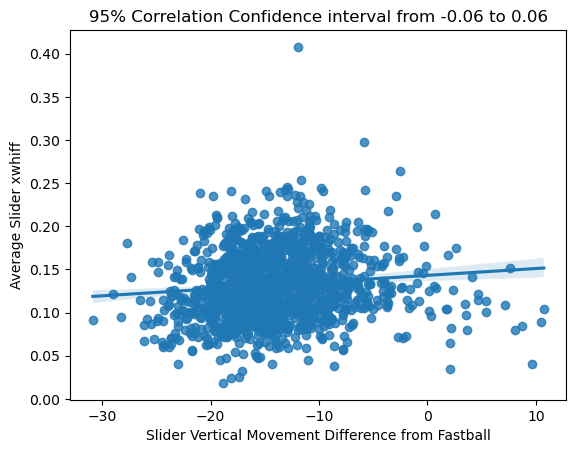

In [243]:
sns.regplot(RHP,x='Slider_minus_Fastball_InducedVertBreak',y='Slider_xwhiff')
lower, upper = bootstrap_correlation(RHP['Slider_minus_Fastball_InducedVertBreak'],RHP['Slider_xwhiff'])
plt.title(f'95% Correlation Confidence interval from {lower} to {upper}')
plt.xlabel('Slider Vertical Movement Difference from Fastball')
plt.ylabel('Average Slider xwhiff')

Text(0, 0.5, 'Average ChangeUp xwhiff')

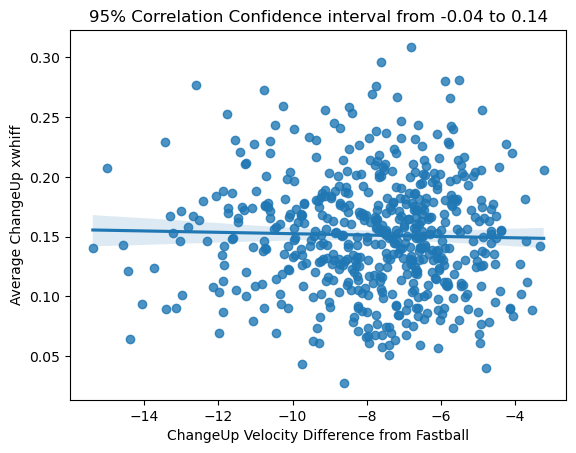

In [244]:
sns.regplot(RHP,x='ChangeUp_minus_Fastball_RelSpeed',y='ChangeUp_xwhiff')
lower, upper = bootstrap_correlation(RHP['ChangeUp_minus_Fastball_RelSpeed'],RHP['ChangeUp_xwhiff'])
plt.title(f'95% Correlation Confidence interval from {lower} to {upper}')
plt.xlabel('ChangeUp Velocity Difference from Fastball')
plt.ylabel('Average ChangeUp xwhiff')


Text(0, 0.5, 'Average ChangeUp xwhiff')

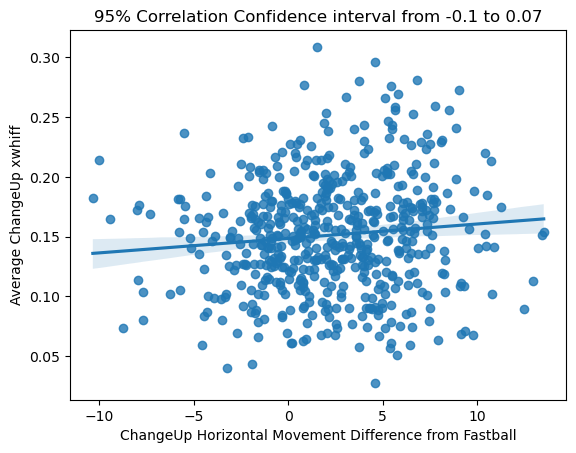

In [245]:
sns.regplot(RHP,x='ChangeUp_minus_Fastball_HorzBreak',y='ChangeUp_xwhiff')
lower, upper = bootstrap_correlation(RHP['ChangeUp_minus_Fastball_HorzBreak'],RHP['ChangeUp_xwhiff'])
plt.title(f'95% Correlation Confidence interval from {lower} to {upper}')
plt.xlabel('ChangeUp Horizontal Movement Difference from Fastball')
plt.ylabel('Average ChangeUp xwhiff')

Text(0, 0.5, 'Average ChangeUp xwhiff')

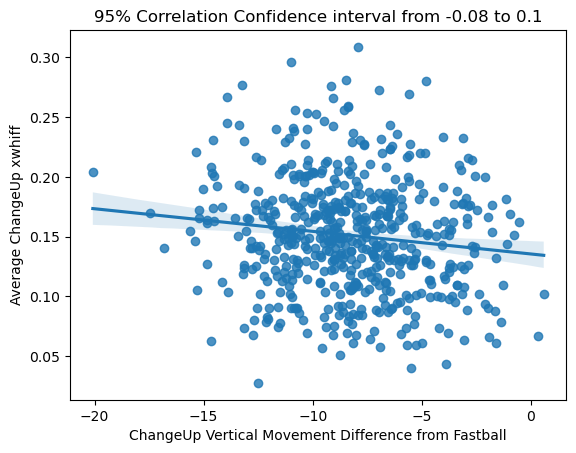

In [246]:
sns.regplot(RHP,x='ChangeUp_minus_Fastball_InducedVertBreak',y='ChangeUp_xwhiff')
lower, upper = bootstrap_correlation(RHP['ChangeUp_minus_Fastball_InducedVertBreak'],RHP['ChangeUp_xwhiff'])
plt.title(f'95% Correlation Confidence interval from {lower} to {upper}')
plt.xlabel('ChangeUp Vertical Movement Difference from Fastball')
plt.ylabel('Average ChangeUp xwhiff')

Text(0, 0.5, 'Average ChangeUp Chase Rate')

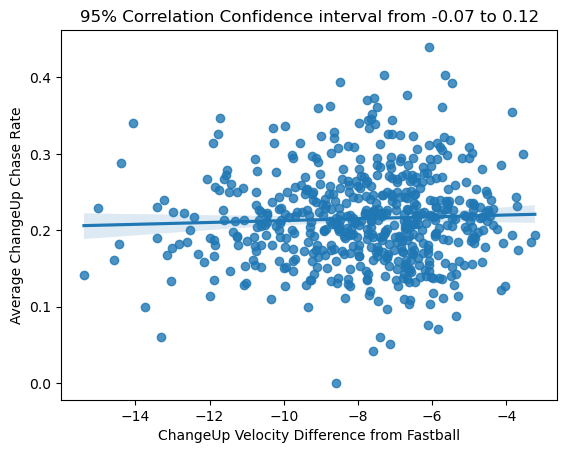

In [247]:
sns.regplot(RHP,x='ChangeUp_minus_Fastball_RelSpeed',y='ChangeUp_chase%')
lower, upper = bootstrap_correlation(RHP['ChangeUp_minus_Fastball_RelSpeed'],RHP['ChangeUp_chase%'])
plt.title(f'95% Correlation Confidence interval from {lower} to {upper}')
plt.xlabel('ChangeUp Velocity Difference from Fastball')
plt.ylabel('Average ChangeUp Chase Rate')


Text(0, 0.5, 'Average Slider Chase Rate')

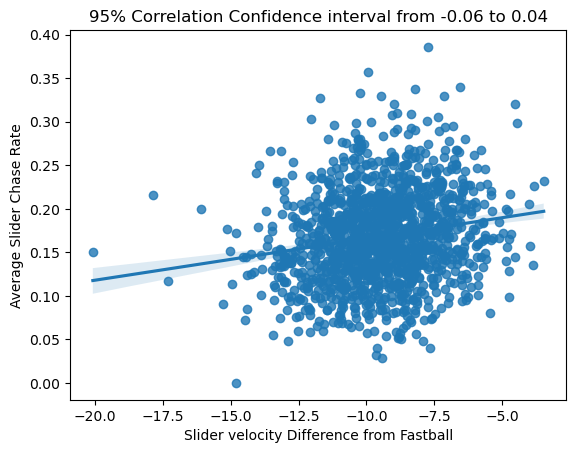

In [248]:
sns.regplot(RHP,x='Slider_minus_Fastball_RelSpeed',y='Slider_chase%')
lower, upper = bootstrap_correlation(RHP['Slider_minus_Fastball_RelSpeed'],RHP['Slider_chase%'])
plt.title(f'95% Correlation Confidence interval from {lower} to {upper}')
plt.xlabel('Slider velocity Difference from Fastball')
plt.ylabel('Average Slider Chase Rate')


# Analysis Results and Interpretation

## Key Finding: No Significant Correlation Between Pitch Differences and Effectiveness

After comprehensive analysis of pitch-to-pitch differences and their relationship to swing-and-miss outcomes, **no statistically significant correlations were found** between pitch separation metrics and xWhiff effectiveness.

## Potential Explanations for Null Results

### 1. Data Quality Challenges
**Subjective Pitch Classification**: Pitch tagging relies on human judgment, creating inconsistency in our foundational categories.

**Example**: Two pitches could both be tagged as "slider" despite vastly different characteristics:
- Slider A: 0" vertical break, -3" horizontal break  
- Slider B: -6" vertical break, -20" horizontal break

This classification inconsistency obscures true relationships between pitch characteristics and outcomes.

### 2. Operator Variability
**Interpretation Differences**: Taggers may have different mental models of pitch types, leading to systematic misclassification that varies by game, venue, or operator.

**Trust Assumption**: Our analysis assumes taggers share consistent pitch type definitions, but this may not hold across the dataset.

### 3. Data Noise from Developmental Context
**College Baseball Environment**: 
- Players are still developing and may experiment with different pitch shapes
- Inconsistent command leads to variable pitch characteristics
- "Average" metrics may not represent a pitcher's true arsenal when they include experimental pitches

**Statistical Impact**: When pitchers throw multiple variants of the same pitch type, averaging creates misleading representative values that don't reflect game situations.

### 4. Alternative Metric Testing
**Chase Rate Analysis**: Created chase rate (% swings on pitches outside strike zone) as a simpler, more fundamental metric than xWhiff.

**Result**: Similar null findings, suggesting the issue may be fundamental rather than metric-specific.

## Implications for Future Research
1. **Higher-Level Data**: Professional data with more consistent tagging might yield different results
2. **Pitch Shape Clustering**: Machine learning approaches to classify pitches by movement rather than human tags
3. **Context-Dependent Analysis**: Focus on specific game situations where tunneling effects might be amplified
4. **Longitudinal Studies**: Track individual pitcher development to control for consistency